# FEUP - AC
## Banking - Predicting a Loan Outcome

### Business understanding

Text

### Exploratory data analysis

Let us start by importing the datasets.

In [3]:
import pandas as pd
import numpy as np

DATA_SOURCE = 'data/'

# Read in the data
accounts = pd.read_csv(DATA_SOURCE + 'account.csv', sep=';')
cards = pd.read_csv(DATA_SOURCE + 'card_dev.csv', sep=';')
clients = pd.read_csv(DATA_SOURCE + 'client.csv', sep=';')
disp = pd.read_csv(DATA_SOURCE + 'disp.csv', sep=';')
districts = pd.read_csv(DATA_SOURCE + 'district.csv', sep=';')
loans = pd.read_csv(DATA_SOURCE + 'loan_dev.csv', sep=';')
transactions = pd.read_csv(DATA_SOURCE + 'trans_dev.csv', sep=';')

print(loans)

     loan_id  account_id    date  amount  duration  payments  status
0       5314        1787  930705   96396        12      8033      -1
1       5316        1801  930711  165960        36      4610       1
2       6863        9188  930728  127080        60      2118       1
3       5325        1843  930803  105804        36      2939       1
4       7240       11013  930906  274740        60      4579       1
..       ...         ...     ...     ...       ...       ...     ...
323     6818        9030  961212  155616        48      3242       1
324     5625        3189  961215  222180        60      3703      -1
325     6805        8972  961221   45024        48       938       1
326     7233       10963  961225  115812        36      3217       1
327     7308       11362  961227  129408        24      5392       1

[328 rows x 7 columns]


/tmp/ipykernel_4055/3455949170.py:13: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  transactions = pd.read_csv(DATA_SOURCE + 'trans_dev.csv', sep=';')


Plenty of analysis with graphs, distributions, outliers...

### Data preprocessing

Text

#### Processing accounts

The account spreadsheet relates it with the district and date in which it was created, as well with the frequency of issuance of statements with the owner.

The date comes in the from YYMMDD, which is easily extractable to the three different columns that it is aggregating. This will aid the model in detecting important patterns in the year of creation, for example, indicating a global economic crisis or prosperity when the person has created the account.

In [4]:
import src.preprocess as pp

pp.extract_date(accounts, "date")
accounts.head()

,account_id,district_id,frequency,year,month,day
0,576,55,monthly issuance,93,1,1
1,3818,74,monthly issuance,93,1,1
2,704,55,monthly issuance,93,1,1
3,2378,16,monthly issuance,93,1,1
4,2632,24,monthly issuance,93,1,2


#### Processing credit cards

In the credit cards relation, the same concept applies to the date of issuance. The type is an enumeration and the other two columns are references which are not treatable at this stage.

In [5]:
cards = pp.extract_date(cards, "issued")
cards.head()

,card_id,disp_id,type,year,month,day
0,1005,9285,classic,93,11,7
1,104,588,classic,94,1,19
2,747,4915,classic,94,2,5
3,70,439,classic,94,2,8
4,577,3687,classic,94,2,15


#### Processing clients

In the clients relation, two foreign references and a date appear once again. However, regarding the latter one, there is an important difference: the day is the actual day plus fifty, if the client is a female, and so we can extract the gender too, here.

In [6]:
client = pp.extract_date(clients, "birth_number", True)
client.head()

,client_id,district_id,year,month,day,gender
0,1,18,70,12,13,female
1,2,1,45,2,4,male
2,3,1,40,10,9,female
3,4,5,56,12,1,male
4,5,5,60,7,3,female


#### Processing dispositions

The disposition describes the rights of clients to operate accounts: only "owners" can ask for loans and issue permanent orders. As of now, there is no processing here.

In [7]:
# maybe remove outliers later...

#### Processing districts

The districts relation is quite dense, describing the demographic data of a region. We can extract interesting measures here:

- The commited crimes growth ratio, derived from the evolution of the number of crimes from '95 to '96
- The unemployment rate growth ratio, derived from the evolution of the employment rate from '95 to '96

We also acknowledged that there was one region where the number of crimes and unemployment rate in '95 was not known (`?` was the appearance in the respective column). In order not to discard the entire region data, we'll simply assume that number to be the same as the matching record in '96.

In [8]:
import numpy as np
districts["no. of commited crimes '95"] = np.where(districts["no. of commited crimes '95"].eq("?"), districts["no. of commited crimes '96"], districts["no. of commited crimes '95"])
districts = districts.astype({"no. of commited crimes '95": int, "no. of commited crimes '96": int})
districts["crime_growth"] = districts["no. of commited crimes '96"] / districts["no. of commited crimes '95"]

districts["unemploymant rate '95"] = np.where(districts["unemploymant rate '95"].eq("?"), districts["unemploymant rate '96"], districts["unemploymant rate '95"])
districts = districts.astype({"unemploymant rate '95": float, "unemploymant rate '96": float})
districts["unemploymant_growth"] = districts["unemploymant rate '96"] / districts["unemploymant rate '95"]

districts.head()

,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,crime_growth,unemploymant_growth
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107,1.156752,1.482759
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674,1.238536,1.107784
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813,0.996105,1.133333
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892,1.123570,1.088362
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040,1.162080,1.150649


#### Processing loans

The loans relation references an account and the date of loan, which can be extracted. The duration seems to be in months, so let us improve the name of the column. The amounts seems to be in `Czech korunas`, the czech currency, as hinted by the list of regions; we'll convert it to euros for better visualization and understanding of the upcoming results. The status, which we want to predict, is either `1` for regular status of `-1` for debt; let us translate it to a string for clarity.

In [9]:
loans = pp.extract_date(loans, "date")
loans = pp.korunas_to_euros(loans, "amount")
loans = pp.korunas_to_euros(loans, "payments")
loans.rename(columns = {'payments':'monthly_payment', 'duration': 'duration_months'}, inplace = True)
loans["status"] = np.where(loans["status"].eq(1), "regular", "debt")
loans.head()

,loan_id,account_id,amount,duration_months,monthly_payment,status,year,month,day
0,5314,1787,3950.66,12,329.22,debt,93,7,5
1,5316,1801,6801.64,36,188.93,regular,93,7,11
2,6863,9188,5208.20,60,86.80,regular,93,7,28
3,5325,1843,4336.23,36,120.45,regular,93,8,3
4,7240,11013,11259.84,60,187.66,regular,93,9,6


#### Processing `trans_dev.csv`

This table contains a lot of information that we cannot directly relate to a loan.

Let us first extract the date and make the withdrawal amounts actually negative, to give the model an impression of the direction of the money flow in and out of the bank.

For now, let us extract some statistical data related to the accounts, which we'll relate to the loans table.

In [10]:
transactions = pp.extract_date(transactions, "date")
transactions = pp.korunas_to_euros(transactions, "amount")
transactions = pp.korunas_to_euros(transactions, "balance")
transactions["amount"] = np.where(transactions["type"].eq("credit"), transactions["amount"], transactions["amount"] * -1)
transactions.head()

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day
0,1548749,5270,credit,credit in cash,32.79,32.79,NaN,NaN,NaN,93,1,13
1,1548750,5270,credit,collection from another bank,1833.98,1866.76,NaN,IJ,80269753.0,93,1,14
2,3393738,11265,credit,credit in cash,40.98,40.98,NaN,NaN,NaN,93,1,14
3,3122924,10364,credit,credit in cash,45.08,45.08,NaN,NaN,NaN,93,1,17
4,1121963,3834,credit,credit in cash,28.69,28.69,NaN,NaN,NaN,93,1,19


In [11]:
average_account_balances = transactions.groupby(["account_id"])["balance"].mean().to_frame()
average_account_balances.head()

,balance
account_id,
1,719.619204
2,1335.681481
4,969.205128
6,1242.347823
7,946.265000


### Statistics

##### Loans stats

Text(0, 0.5, 'y - monthly payment')

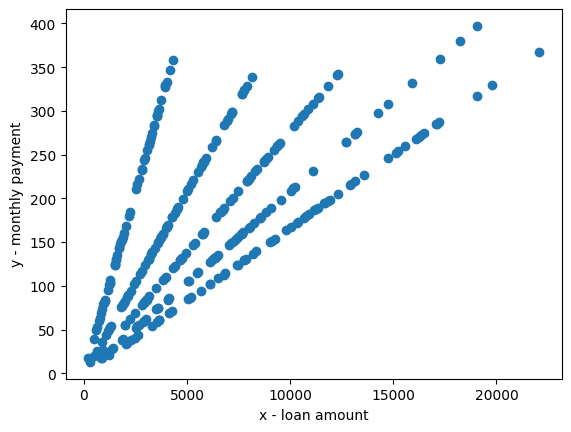

In [22]:
import matplotlib.pyplot as plt

plt.scatter(loans["amount"],loans["monthly_payment"])
plt.xlabel('x - loan amount')
plt.ylabel('y - monthly payment')

In [1]:
#TODO
data = []

#print(loans[loans["duration"] < 30])

#for i in range(0, 400, 50):
#    temp = []
#    temp.append((loans[loans["duration"] < i])["monthly_payment"])

#plt.boxplot(loans["monthly_payment"])
#plt.xlabel('x - duration')
#plt.ylabel('y - monthly payment')

NameError: name 'loans' is not defined

Text(0, 0.5, 'y - monthly payment')

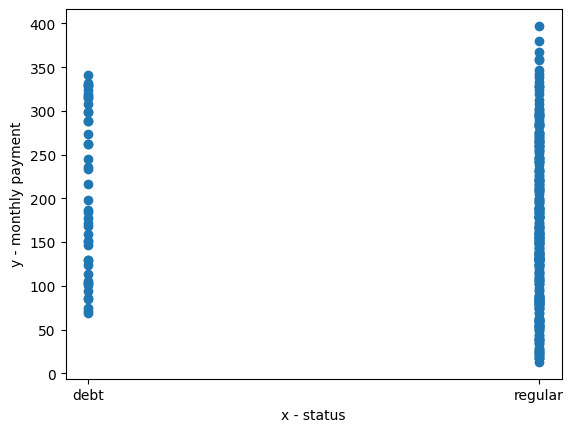

In [30]:
plt.scatter(loans["status"],loans["monthly_payment"])
plt.xlabel('x - status')
plt.ylabel('y - monthly payment')

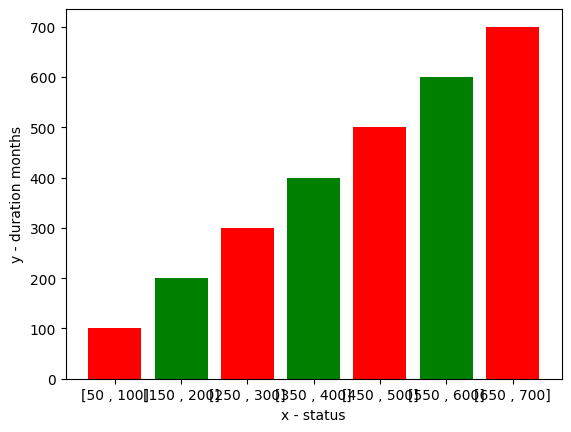

<Figure size 4000x300 with 0 Axes>

In [45]:
#TODO
left = []
height = []
for i in range(50, 400, 50):
        height.append(i*2)
        left.append(i/50)

plt.bar(left, height, tick_label = [f'[{i-50} , {i}]' for i in height],
        width = 0.8, color = ['red', 'green'])
  
plt.xlabel('x - status')
plt.ylabel('y - duration months')
  
plt.show()

#### Merging the data

Text

In [63]:
average_account_balances.rename(columns = {'balance':'account_average_balance'}, inplace = True)
accounts = accounts.merge(average_account_balances, on="account_id")
accounts.head()

,account_id,district_id,frequency,year,month,day,average_account_balance
0,576,55,monthly issuance,93,1,1,995.213406
1,3818,74,monthly issuance,93,1,1,1755.200383
2,704,55,monthly issuance,93,1,1,1424.108906
3,2378,16,monthly issuance,93,1,1,2376.927362
4,2632,24,monthly issuance,93,1,2,1326.053913


In [64]:
accounts = accounts.rename(columns = {'year':'account_year', 'month':'account_month', 'day':'account_day', 'frequency': 'account_frequency', 'district_id': 'account_district_id'})
loans = loans.merge(accounts, on="account_id")
loans.head()

,loan_id,account_id,amount,duration_months,monthly_payment,status,year,month,day,account_district_id,account_frequency,account_year,account_month,account_day,average_account_balance
0,5314,1787,3950.66,12,329.22,debt,93,7,5,30,weekly issuance,93,3,22,502.047500
1,5316,1801,6801.64,36,188.93,regular,93,7,11,46,monthly issuance,93,2,13,2134.584324
2,6863,9188,5208.20,60,86.80,regular,93,7,28,45,monthly issuance,93,2,8,1232.007083
3,5325,1843,4336.23,36,120.45,regular,93,8,3,12,monthly issuance,93,1,30,1692.519600
4,7240,11013,11259.84,60,187.66,regular,93,9,6,1,weekly issuance,93,2,14,2343.778889


#### Feature engineering

Text

In [65]:
# extract columns

### Training the model

Text

#### Splitting the data for training

Text

In [66]:
from sklearn.model_selection import train_test_split

target = loans.status.values
independent = loans.drop('status', axis=1).values

# Make sure to split by future date later...
x_train, x_test, y_train, y_test = train_test_split(
        independent, target, test_size=0.2)

#### Feeding the model

Evaluate classification model performance with loans table

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

# Create a Random Forest Model
random_classifier = RandomForestClassifier(
    n_estimators=100)

# Train it with data
random_classifier.fit(x_train, y_train)

# Predict the test data
predictions = random_classifier.predict(x_test)

# Check the accuracy
print(recall_score(y_test, predictions, pos_label="debt"))

ValueError: could not convert string to float: 'monthly issuance'

### Evaluating the model

Text